# compile data set for NOAH2 project
This dataset is a compilation of the NOAH project dataset matched to CIDs from the CRS dataset. It includes points that CRS participants scored on the different CRS activites: `fema_cid.fsf_cenus_rainfall.csv`. See `/nb/points/fema_cid_merge.ipynb` and `nb/points/fema_cid.add_fsf_census_rainfall.ipynb` for details on how it was compiled.

In this notebook, we will combine this with some additional information and save it in an easily usable format. 

In [1]:
import os
import numpy as np 
from astropy.table import join as aJ
from astropy.table import Table as aT

In [2]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## noah dataset + CID info

In [3]:
fema = aT.read('../dat/fema_cid.fsf_cenus_rainfall.csv')

In [4]:
print('%i entries' % len(fema))

646512 entries


In [5]:
fema[:5]

agricultureStructureIndicator,asOfDate,baseFloodElevation,basementEnclosureCrawlspace,reportedCity,condominiumIndicator,policyCount,countyCode,communityRatingSystemDiscount,dateOfLoss,elevatedBuildingIndicator,elevationCertificateIndicator,elevationDifference,censusTract,floodZone,houseWorship,latitude,longitude,locationOfContents,lowestAdjacentGrade,lowestFloorElevation,numberOfFloorsInTheInsuredBuilding,nonProfitIndicator,obstructionType,occupancyType,originalConstructionDate,originalNBDate,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,amountPaidOnIncreasedCostOfComplianceClaim,postFIRMConstructionIndicator,rateMethod,smallBusinessIndicatorBuilding,state,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,yearOfLoss,zipcode,primaryResidence,id,amountPaidOnTotalClaim,totalTotalInsuranceCoverage,monthOfLoss,cid,COMMUNITY NAME,STATE,cTot,REGION,CLASS,bSF,aSFHA,CGA,c310,Year_310,EC,cEC,ECPO,cECPO,ECPR,cECPR,c320,Year_320,MI1,MI2,MI3,MI4,MI5,MI6,MI7,cMI,c330,Year_330,Sum OP,Sum PPI (OP),Sum STK (OP),cOP,Sum FRP,Sum PPI (FRP),cFRP,c340,Year_340,DFH,ODR,REB,DOH,c350,Year_350,LIB,LPD,WEB1,WEB2,WEB3,WEB4,cWEB,c360,Year_360,PPA,cPPA,PPV,cPPV,FAA,cFAA,TNG,c370,Year_370,FIA,CP,Sum CPI,Sum PPI,Sum STK,cCPI,TA,cTA,c410,CGA410,Year_410,NS1,NS2,NS3,NS4,NS5,NS6,LEV1,LEV2,LEV3,LEV4,LEV5,LEV6,SR1,SR2,SR3,SR4,SR5,SR6,HSS1,HSS2,HSS3,HSS4,HSS5,HSS6,FWS1,FWS2,FWS3,FWS4,FWS5,FWS6,CTP21,CTP22,CTP23,CTP24,CTP25,CTP26,rMAP#1,rMAP#2,rMAP#3,rMAP#4,rMAP#5,rMAP#6,MAP#1,MAP#2,MAP#3,MAP#4,MAP#5,MAP#6,MAPSH,CTP1,aSFT,c420,CGA420,Year_420,cOSP,cDR,NFOS1,NFOS2,NFOS3,NFOS4,NFOS5,cNFOS,cSHOS,OSI1,OSI2,OSI3,OSI4,OSI5,OSI6,OSI7,cOSI,S#1,LZs#1,S#2,LZs#2,S#3,LZs#3,cLZ,NSP,cNSP,c430,CGA430,Year_430,DL1a#1,DL1a#2,DL1a#3,DL1b#1,DL1b#2,DL1b#3,DL2#1,DL2#2,DL2#3,DL3a#1,DL3a#2,DL3a#3,DL3b#1,DL3b#2,DL3b#3,DL3c#1,DL3c#2,DL3c#3,cDL,FRB1,FRB2,FRB3,cFRB,FDN1,FDN2,FDN3,cFDN,CSI1#1,CSI1#2,CSI1#3,CSI2#1,CSI2#2,CSI2#3,CSI3#1,CSI3#2,CSI3#3,CSI4#1,CSI4#2,CSI4#3,CSI#1,CSI#2,CSI#3,cCSI,LSI#1,LSI#2,LSI#3,cLSI,PCF1#1,PCF1#2,PCF1#3,PCF2#1,PCF2#2,PCF2#3,cPCF,"ENL1,2#1","ENL1,2#2","ENL1,2#3",ENL3#1,ENL3#2,ENL3#3,cENL,BC1,BC2,cBC,LDP1,LDP2,LDP3,LDP4,cLDP,MHP,cMHP,CAZ1#1,CAZ1#2,CAZ1#3,CAZ2#1,CAZ2#2,CAZ2#3,CAZ#1,CAZ#2,CAZ#3,cCAZ,SHR#1,SHR#2,SHR#3,cSHR,OHS#1,OHS#2,OHS#3,cOHS,cSMS,RA1,RA2,RA3,RA4,RA5,cRA,c440,CGA440,Year_440,AMD1,AMD2,AMD3,cAMD,FM,BMM1,BMM2,cBMM,EDM,c450,CGA450,Year_450,SZ1,SZ2,SZ3,DS1,DS2,DS3,LID1,LID2,LID3,PUB1,PUB2,PUB3,SMR1,SMR2,SMR3,cSMR,WMP1,WMP2,WMP3,cWMP,ESC,cESC,WQ,cWQ,c510,Year_510,FMP,cFMP,RLAA#1,RLAA#2,RLAA#3,cRLAA,NFP1,NFP2,cNFP,c520,Year_520,bAR,FMAbAR,cbAR,bRL,FMAbRL,cbRL,bSRL,FMAbSRL,cbSRL,bCF,FMAbCF,cbCF,bVZ,FMAbVZ,cbVZ,c530,Year_530,nPB,Sum PB,c540,Year_540,CDR,cCDR,PSM,cPSM,CIP,cCIP,SDR,SBM,cSBM,EPM,c610,Year_610,FTR1,FTR2,FTR3,cFTR,EWD1,EWD2,EWD3,cEWD,FRO1,FRO2,FRO3,cFRO,cCFP,SRC,TRC,c620,Year_620,cLM,cLFR,cLFW,cLFO,cLCF,c630,Year_630,cSDS,cDFR,cDFW,cDFO,cDCF,col366,_1,_2,count_property,count_fema_sfha,pct_fema_sfha,count_fs_risk_2020_5,pct_fs_risk_2020_5,count_fs_risk_2050_5,pct_fs_risk_2050_5,count_fs_risk_2020_100,pct_fs_risk_2020_100,count_fs_risk_2050_100,pct_fs_risk_2050_100,count_fs_risk_2020_500,pct_fs_risk_2020_500,count_fs_risk_2050_500,pct_fs_risk_2050_500,pct_fs_fema_difference_2020,avg_risk_score_all,avg_risk_score_2_10,avg_risk_fsf_2020_100,avg_risk_fsf_2020_500,avg_risk_score_sfha,avg_risk_score_no_sfha,count_floodfactor1,count_floodfactor2,count_floodfactor3,count_floodfactor4,count_floodfactor5,count_floodfactor6,count_floodfactor7,count_floodfactor8,count_floodfactor9,count_floodfactor10,population,median_household_income,renter_fraction,educated_fraction,white_fraction,AREA,mean_rainfall,sum_rainfall,median_rainfall,risky,s_c310,s_c320,s_c330,s_c340,s_c350,s_c360,s_c370,s_c410,s_c420,s_c430,s_c440,s_c450,s_c510,s_c520,s_c530,s_c540,s_c610,s_c620,s_c630,s_c300_avg,s_c400_avg,s_c500_avg,s_c600_avg
int64,str24,int64,int64,str29,str1,int64,int64,int64,str24,int64,int64,int64,int64,str3,int64,float64,float64,int64,float64,int64,i

## add urban/rural info from the RUCA dataset
csv file is exported from the `RUCA2010zipcode.xlsx` dataset in 
https://www.ers.usda.gov/data-products/rural-urban-commuting-area-codes/

In [6]:
ruca = aT.read('../dat/ruca2010zipcode.csv')

In [7]:
ruca.rename_column('ZIP_CODE', 'zipcode')

In [8]:
ruca[:5]

zipcode,STATE,ZIP_TYPE,RUCA1,RUCA2
int64,str2,str36,int64,float64
1,AK,Zip Code Area,10,10.0
2,AK,Zip Code Area,10,10.0
3,AK,Zip Code Area,10,10.0
4,AK,Zip Code Area,10,10.0
5,AK,Zip Code Area,10,10.0


In [9]:
fema = aJ(fema, ruca['zipcode', 'RUCA1', 'RUCA2'], keys='zipcode', join_type='left') 

In [10]:
fema[:5]

agricultureStructureIndicator,asOfDate,baseFloodElevation,basementEnclosureCrawlspace,reportedCity,condominiumIndicator,policyCount,countyCode,communityRatingSystemDiscount,dateOfLoss,elevatedBuildingIndicator,elevationCertificateIndicator,elevationDifference,censusTract,floodZone,houseWorship,latitude,longitude,locationOfContents,lowestAdjacentGrade,lowestFloorElevation,numberOfFloorsInTheInsuredBuilding,nonProfitIndicator,obstructionType,occupancyType,originalConstructionDate,originalNBDate,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,amountPaidOnIncreasedCostOfComplianceClaim,postFIRMConstructionIndicator,rateMethod,smallBusinessIndicatorBuilding,state,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,yearOfLoss,zipcode,primaryResidence,id,amountPaidOnTotalClaim,totalTotalInsuranceCoverage,monthOfLoss,cid,COMMUNITY NAME,STATE,cTot,REGION,CLASS,bSF,aSFHA,CGA,c310,Year_310,EC,cEC,ECPO,cECPO,ECPR,cECPR,c320,Year_320,MI1,MI2,MI3,MI4,MI5,MI6,MI7,cMI,c330,Year_330,Sum OP,Sum PPI (OP),Sum STK (OP),cOP,Sum FRP,Sum PPI (FRP),cFRP,c340,Year_340,DFH,ODR,REB,DOH,c350,Year_350,LIB,LPD,WEB1,WEB2,WEB3,WEB4,cWEB,c360,Year_360,PPA,cPPA,PPV,cPPV,FAA,cFAA,TNG,c370,Year_370,FIA,CP,Sum CPI,Sum PPI,Sum STK,cCPI,TA,cTA,c410,CGA410,Year_410,NS1,NS2,NS3,NS4,NS5,NS6,LEV1,LEV2,LEV3,LEV4,LEV5,LEV6,SR1,SR2,SR3,SR4,SR5,SR6,HSS1,HSS2,HSS3,HSS4,HSS5,HSS6,FWS1,FWS2,FWS3,FWS4,FWS5,FWS6,CTP21,CTP22,CTP23,CTP24,CTP25,CTP26,rMAP#1,rMAP#2,rMAP#3,rMAP#4,rMAP#5,rMAP#6,MAP#1,MAP#2,MAP#3,MAP#4,MAP#5,MAP#6,MAPSH,CTP1,aSFT,c420,CGA420,Year_420,cOSP,cDR,NFOS1,NFOS2,NFOS3,NFOS4,NFOS5,cNFOS,cSHOS,OSI1,OSI2,OSI3,OSI4,OSI5,OSI6,OSI7,cOSI,S#1,LZs#1,S#2,LZs#2,S#3,LZs#3,cLZ,NSP,cNSP,c430,CGA430,Year_430,DL1a#1,DL1a#2,DL1a#3,DL1b#1,DL1b#2,DL1b#3,DL2#1,DL2#2,DL2#3,DL3a#1,DL3a#2,DL3a#3,DL3b#1,DL3b#2,DL3b#3,DL3c#1,DL3c#2,DL3c#3,cDL,FRB1,FRB2,FRB3,cFRB,FDN1,FDN2,FDN3,cFDN,CSI1#1,CSI1#2,CSI1#3,CSI2#1,CSI2#2,CSI2#3,CSI3#1,CSI3#2,CSI3#3,CSI4#1,CSI4#2,CSI4#3,CSI#1,CSI#2,CSI#3,cCSI,LSI#1,LSI#2,LSI#3,cLSI,PCF1#1,PCF1#2,PCF1#3,PCF2#1,PCF2#2,PCF2#3,cPCF,"ENL1,2#1","ENL1,2#2","ENL1,2#3",ENL3#1,ENL3#2,ENL3#3,cENL,BC1,BC2,cBC,LDP1,LDP2,LDP3,LDP4,cLDP,MHP,cMHP,CAZ1#1,CAZ1#2,CAZ1#3,CAZ2#1,CAZ2#2,CAZ2#3,CAZ#1,CAZ#2,CAZ#3,cCAZ,SHR#1,SHR#2,SHR#3,cSHR,OHS#1,OHS#2,OHS#3,cOHS,cSMS,RA1,RA2,RA3,RA4,RA5,cRA,c440,CGA440,Year_440,AMD1,AMD2,AMD3,cAMD,FM,BMM1,BMM2,cBMM,EDM,c450,CGA450,Year_450,SZ1,SZ2,SZ3,DS1,DS2,DS3,LID1,LID2,LID3,PUB1,PUB2,PUB3,SMR1,SMR2,SMR3,cSMR,WMP1,WMP2,WMP3,cWMP,ESC,cESC,WQ,cWQ,c510,Year_510,FMP,cFMP,RLAA#1,RLAA#2,RLAA#3,cRLAA,NFP1,NFP2,cNFP,c520,Year_520,bAR,FMAbAR,cbAR,bRL,FMAbRL,cbRL,bSRL,FMAbSRL,cbSRL,bCF,FMAbCF,cbCF,bVZ,FMAbVZ,cbVZ,c530,Year_530,nPB,Sum PB,c540,Year_540,CDR,cCDR,PSM,cPSM,CIP,cCIP,SDR,SBM,cSBM,EPM,c610,Year_610,FTR1,FTR2,FTR3,cFTR,EWD1,EWD2,EWD3,cEWD,FRO1,FRO2,FRO3,cFRO,cCFP,SRC,TRC,c620,Year_620,cLM,cLFR,cLFW,cLFO,cLCF,c630,Year_630,cSDS,cDFR,cDFW,cDFO,cDCF,col366,_1,_2,count_property,count_fema_sfha,pct_fema_sfha,count_fs_risk_2020_5,pct_fs_risk_2020_5,count_fs_risk_2050_5,pct_fs_risk_2050_5,count_fs_risk_2020_100,pct_fs_risk_2020_100,count_fs_risk_2050_100,pct_fs_risk_2050_100,count_fs_risk_2020_500,pct_fs_risk_2020_500,count_fs_risk_2050_500,pct_fs_risk_2050_500,pct_fs_fema_difference_2020,avg_risk_score_all,avg_risk_score_2_10,avg_risk_fsf_2020_100,avg_risk_fsf_2020_500,avg_risk_score_sfha,avg_risk_score_no_sfha,count_floodfactor1,count_floodfactor2,count_floodfactor3,count_floodfactor4,count_floodfactor5,count_floodfactor6,count_floodfactor7,count_floodfactor8,count_floodfactor9,count_floodfactor10,population,median_household_income,renter_fraction,educated_fraction,white_fraction,AREA,mean_rainfall,sum_rainfall,median_rainfall,risky,s_c310,s_c320,s_c330,s_c340,s_c350,s_c360,s_c370,s_c410,s_c420,s_c430,s_c440,s_c450,s_c510,s_c520,s_c530,s_c540,s_c610,s_c620,s_c630,s_c300_avg,s_c400_avg,s_c500_avg,s_c600_avg,RUCA1,RUCA2
int64,str24,int64,int64,str29,str1,int64,int64,int64,str24,int64,int64,int64,int64,str3,int64,float64,float64,int64,flo

## calculate total claim per policy

In [11]:
fema['amountPaidOnTotalClaim_per_policy'] = fema['amountPaidOnTotalClaim']/fema['policyCount']

## scale CRS activity points
The points for CRS activities are in arbitrary units. Lets scale them so they all span 0-100

In [12]:
activities = [] 
for col in fema.colnames: 
    if 's_c' in col and '_avg' not in col:
        activities.append(col[2:])

In [13]:
for activity in activities: 
    fema['s_'+activity] = fema[activity]/ (fema[activity].max() - fema[activity].min()) * 100.
    print(activity, fema[activity].min(), fema[activity].max())

c310 0 116
c320 0 90
c330 0 350
c340 0 67
c350 0 125
c360 0 110
c370 0 110
c410 0 326
c420 0 1603
c430 0 1335
c440 0 249
c450 0 595
c510 0 602
c520 0 1999
c530 0 541
c540 0 465
c610 0 365
c620 0 205
c630 0 99


## trim and save

In [14]:
# file is quite heavy so lets remove some spurious columns. 
# This can always be revisited later for an updated version
fema.remove_columns(['agricultureStructureIndicator', 'asOfDate', 'baseFloodElevation', 
                     'basementEnclosureCrawlspace', 'elevatedBuildingIndicator', 'elevationCertificateIndicator',
                     'elevationDifference', 'censusTract', 'houseWorship', 'lowestAdjacentGrade', 
                     'lowestFloorElevation', 'numberOfFloorsInTheInsuredBuilding', 'nonProfitIndicator', 
                     'obstructionType', 'occupancyType', 'originalConstructionDate', 'originalNBDate', 
                     'amountPaidOnIncreasedCostOfComplianceClaim', 'postFIRMConstructionIndicator', 
                     'rateMethod', 'smallBusinessIndicatorBuilding'])

## clean dataset a bit

In [15]:
to_remove = (
    (fema['median_household_income'] == 0) | 
    (fema['population'] == 0))
print('removing %i questionable entries' % np.sum(to_remove))

removing 333 questionable entries


In [16]:
masked = np.zeros(len(fema)).astype(bool)
for col in ['amountPaidOnTotalClaim_per_policy', 'mean_rainfall', 'avg_risk_score_all', 'median_household_income', 
                'population', 'renter_fraction', 'educated_fraction', 'white_fraction']: 
    try:
        print("%s, %i, %.2f" % (col, np.sum(fema[col].mask), np.mean(fema[col].mask)))
        masked |= fema[col].mask
    except: 
        print("%s is not masked" % col)

amountPaidOnTotalClaim_per_policy is not masked
mean_rainfall, 87638, 0.14
avg_risk_score_all is not masked
median_household_income is not masked
population is not masked
renter_fraction is not masked
educated_fraction is not masked
white_fraction is not masked


In [17]:
print("masked: %i, %.2f" % (np.sum(masked), np.mean(masked)))

masked: 87638, 0.14


In [18]:
fema = fema[~to_remove & ~masked]

In [19]:
print(len(fema))

558573


In [20]:
fema.write('../dat/noah2.v0.1.csv', overwrite=True)

## no CRS activity
There are a large number of communities that do not participate (i.e. score 0 points total for all activites). Lets examine these communities since we will have to exclude them. 

In [21]:
# calculate the total points 
total_points = np.zeros(len(fema))
for activity in activities: 
    total_points += np.array(fema[activity])
    
no_points = (total_points == 0.) # these entries have no CRS points D:
print('%i entries; %.1f percent of the catalog' % (np.sum(no_points), 100*np.mean(no_points)))

391212 entries; 70.0 percent of the catalog


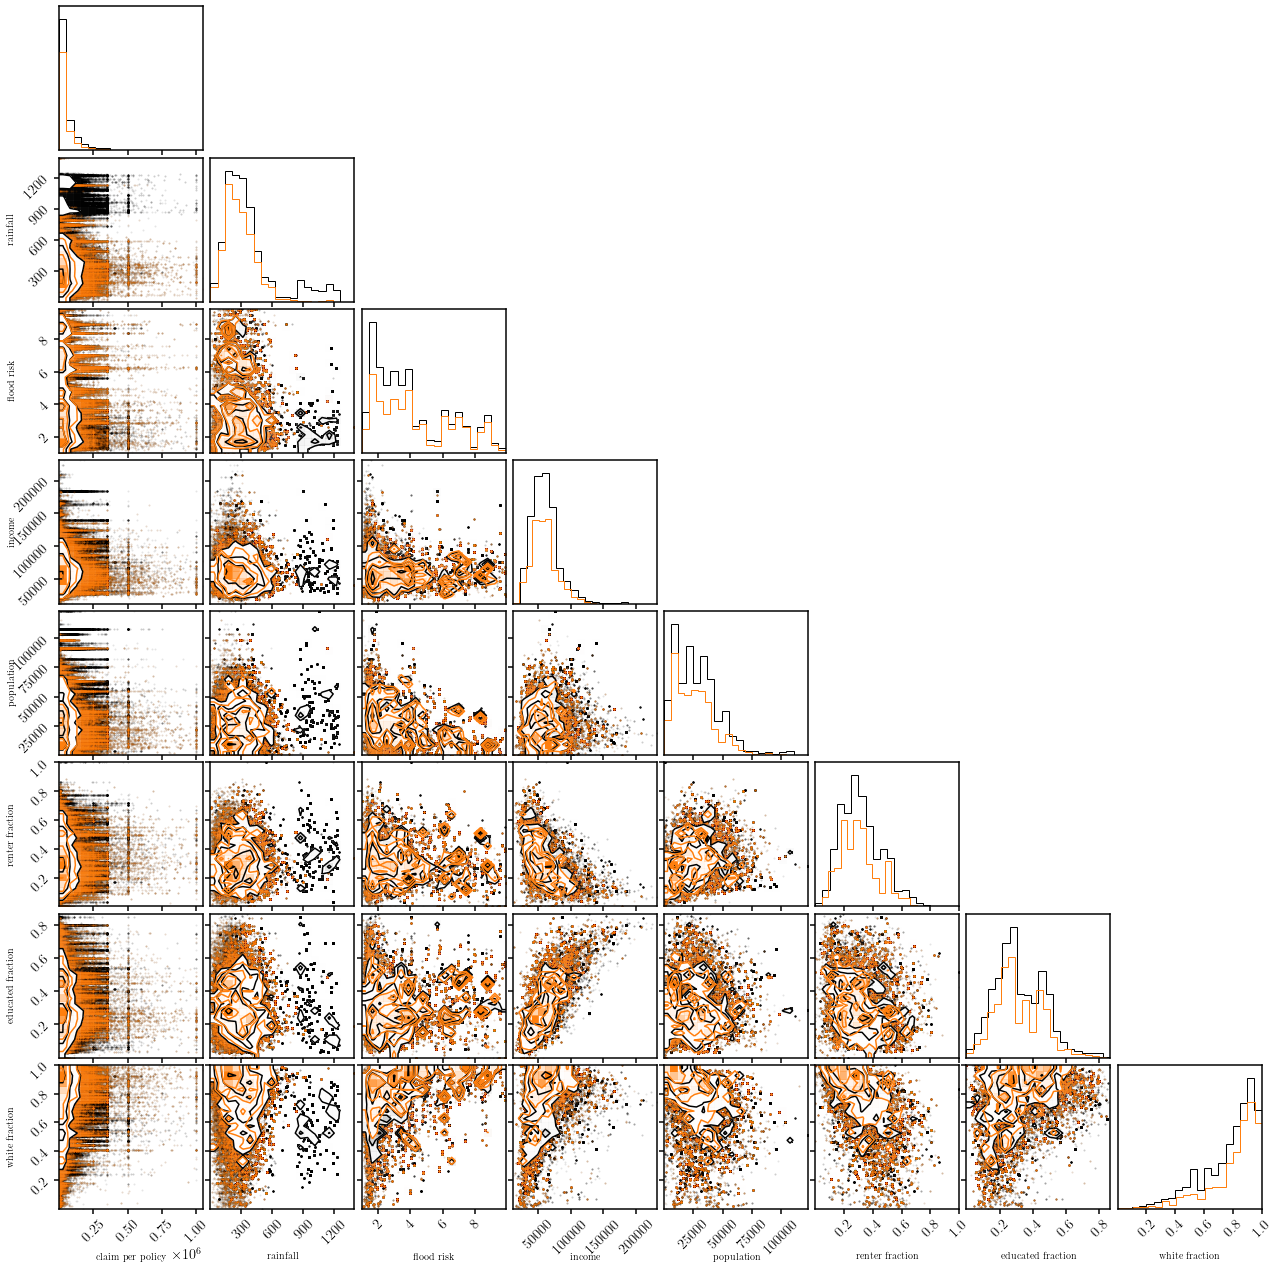

In [22]:
columns = ['amountPaidOnTotalClaim_per_policy', 'mean_rainfall', 'avg_risk_score_all', 
           'median_household_income', 'population', 'renter_fraction', 'educated_fraction', 'white_fraction'] 
labels = ['claim per policy', 'rainfall', 'flood risk', 'income', 
          'population', 'renter fraction', 'educated fraction', 'white fraction']

_data = np.array([np.array(fema[col]) for col in columns])

fig = DFM.corner(_data.T, color='k')
_ = DFM.corner(_data.T[no_points], color='C1', labels=labels, fig=fig)

lets checkout the leftover communities

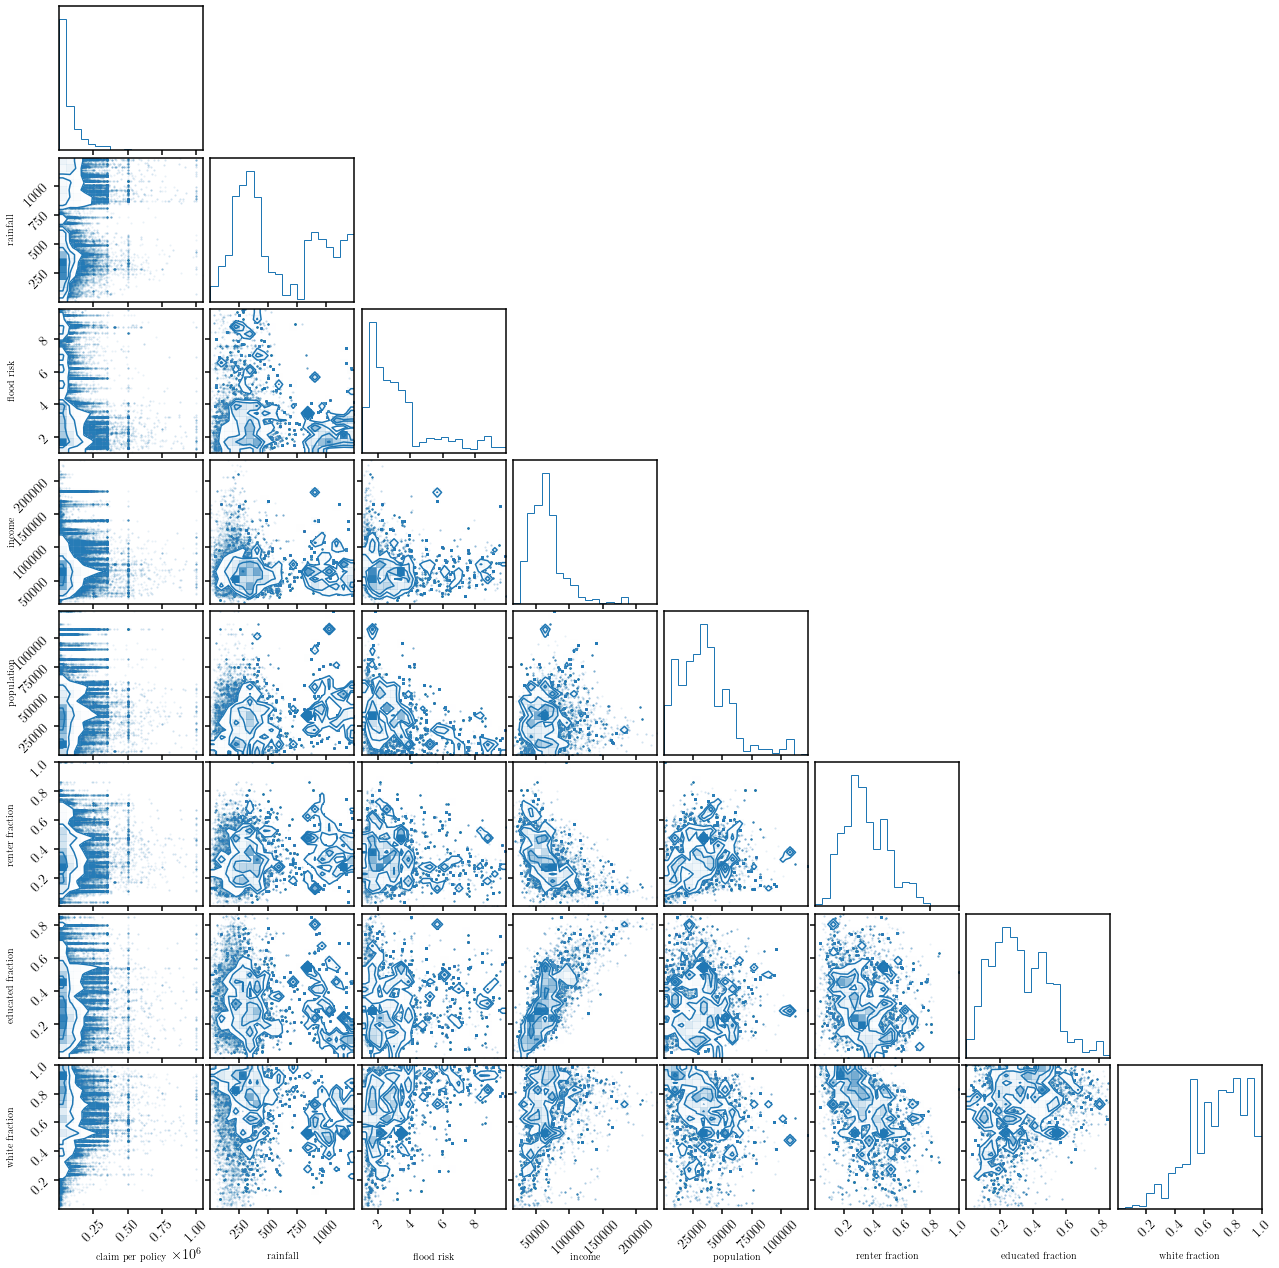

In [23]:
fig = DFM.corner(_data.T[~no_points], color='C0', labels=labels)

In [24]:
# remove non-participating entries
fema = fema[~no_points]
fema.write('../dat/noah2.participants.v0.1.csv', overwrite=True)